# Import Libraries

In [17]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [18]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ToTensor(),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])


# Dataset and Creating Train/Test Split

In [19]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [20]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# # dataloader arguments - something you'll fetch these from cmdprmt
# dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# # train dataloader
# train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# # test dataloader
# test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

train_dataloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)


CUDA Available? True


In [ ]:
train.data

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)
 - mean: tensor(120.7076)
 - std: tensor(64.1501)
 - var: tensor(4115.2324)
torch.Size([64, 3, 32, 32])
torch.Size([64])


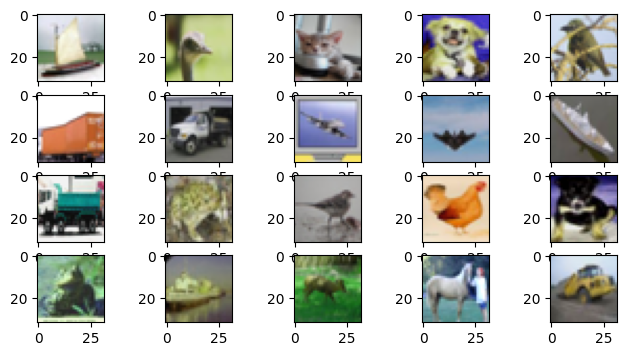

In [21]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())
train_data = train.data

torch_tensor = torch.from_numpy(train_data)

print('[Train]')
print(' - Numpy Shape:', train_data.shape)
print(' - Tensor Shape:', torch_tensor.size())
print(' - min:', torch.min(torch_tensor))
print(' - max:', torch.max(torch_tensor))
print(' - mean:', torch.mean(torch_tensor.float()))
print(' - std:', torch.std(torch_tensor.float()))
print(' - var:', torch.var(torch_tensor.float()))

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

images = images.numpy()

plt.figure(figsize=(8,4))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(np.transpose(images[i],(1,2,0))/2+0.5)

plt.show()

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


In [ ]:
images.shape

(64, 3, 32, 32)

# The model
Let's start with the model we first saw

In [22]:
from models import S8_GN_Model
Net = S8_GN_Model

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [23]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
input_channels = model.convblock1[0].in_channels
summary(model, input_size=(input_channels, 32, 32))
# print(model)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 34, 34]             864
         GroupNorm-2           [-1, 32, 34, 34]              64
              ReLU-3           [-1, 32, 34, 34]               0
           Dropout-4           [-1, 32, 34, 34]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
         GroupNorm-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 10, 32, 32]             320
        MaxPool2d-10           [-1, 10, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           2,880
        GroupNorm-12           [-1, 32, 16, 16]              64
             ReLU-13           [-1, 32, 16, 16]               0
          Dropout-14           [-1

In [ ]:
print(model)

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
    (1): GroupNorm(4, 32, eps=1e-05, affine=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): GroupNorm(8, 32, eps=1e-05, affine=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock4): Sequential(
    (0): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): GroupNorm(4, 32, eps=1e-05, affine=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock5): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): GroupNorm(4, 64, eps=1e-05, affine=True)
  

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

EPOCH: 0


Loss=1.9160929918289185 Batch_id=781 Accuracy=34.65: 100%|██████████| 782/782 [01:34<00:00,  8.27it/s]



Test set: Average loss: 1.4728, Accuracy: 4567/10000 (45.67%)

EPOCH: 1


Loss=0.7404060959815979 Batch_id=781 Accuracy=49.39: 100%|██████████| 782/782 [01:31<00:00,  8.55it/s]



Test set: Average loss: 1.3531, Accuracy: 5249/10000 (52.49%)

EPOCH: 2


Loss=1.8843255043029785 Batch_id=781 Accuracy=56.33: 100%|██████████| 782/782 [01:30<00:00,  8.65it/s]



Test set: Average loss: 1.0868, Accuracy: 6177/10000 (61.77%)

EPOCH: 3


Loss=0.895436704158783 Batch_id=781 Accuracy=60.63: 100%|██████████| 782/782 [01:30<00:00,  8.61it/s]



Test set: Average loss: 1.0107, Accuracy: 6433/10000 (64.33%)

EPOCH: 4


Loss=0.9831287860870361 Batch_id=781 Accuracy=63.35: 100%|██████████| 782/782 [01:30<00:00,  8.65it/s]



Test set: Average loss: 0.9863, Accuracy: 6513/10000 (65.13%)

EPOCH: 5


Loss=1.0236852169036865 Batch_id=781 Accuracy=65.59: 100%|██████████| 782/782 [01:30<00:00,  8.62it/s]



Test set: Average loss: 0.9263, Accuracy: 6751/10000 (67.51%)

EPOCH: 6


Loss=1.03013277053833 Batch_id=781 Accuracy=66.86: 100%|██████████| 782/782 [01:31<00:00,  8.50it/s]



Test set: Average loss: 0.9030, Accuracy: 6885/10000 (68.85%)

EPOCH: 7


Loss=1.27913236618042 Batch_id=781 Accuracy=68.35: 100%|██████████| 782/782 [01:32<00:00,  8.49it/s]



Test set: Average loss: 0.9980, Accuracy: 6550/10000 (65.50%)

EPOCH: 8


Loss=0.7154533267021179 Batch_id=781 Accuracy=69.02: 100%|██████████| 782/782 [01:32<00:00,  8.43it/s]



Test set: Average loss: 0.8682, Accuracy: 7004/10000 (70.04%)

EPOCH: 9


Loss=0.8542802333831787 Batch_id=781 Accuracy=69.88: 100%|██████████| 782/782 [01:32<00:00,  8.49it/s]



Test set: Average loss: 0.8405, Accuracy: 7080/10000 (70.80%)

EPOCH: 10


Loss=0.819108247756958 Batch_id=781 Accuracy=70.48: 100%|██████████| 782/782 [01:32<00:00,  8.43it/s]



Test set: Average loss: 0.7847, Accuracy: 7225/10000 (72.25%)

EPOCH: 11


Loss=0.6131279468536377 Batch_id=781 Accuracy=71.28: 100%|██████████| 782/782 [01:32<00:00,  8.43it/s]



Test set: Average loss: 0.7873, Accuracy: 7241/10000 (72.41%)

EPOCH: 12


Loss=1.0440956354141235 Batch_id=781 Accuracy=71.81: 100%|██████████| 782/782 [01:32<00:00,  8.45it/s]



Test set: Average loss: 0.7856, Accuracy: 7264/10000 (72.64%)

EPOCH: 13


Loss=0.7442522644996643 Batch_id=781 Accuracy=72.23: 100%|██████████| 782/782 [01:32<00:00,  8.48it/s]



Test set: Average loss: 0.7937, Accuracy: 7249/10000 (72.49%)

EPOCH: 14


Loss=0.6717963218688965 Batch_id=781 Accuracy=73.01: 100%|██████████| 782/782 [01:33<00:00,  8.38it/s]



Test set: Average loss: 0.8132, Accuracy: 7141/10000 (71.41%)

EPOCH: 15


Loss=1.6231651306152344 Batch_id=781 Accuracy=73.02: 100%|██████████| 782/782 [01:33<00:00,  8.41it/s]



Test set: Average loss: 0.7885, Accuracy: 7223/10000 (72.23%)

EPOCH: 16


Loss=1.0957201719284058 Batch_id=781 Accuracy=73.62: 100%|██████████| 782/782 [01:33<00:00,  8.34it/s]



Test set: Average loss: 0.7644, Accuracy: 7347/10000 (73.47%)

EPOCH: 17


Loss=0.3804415762424469 Batch_id=781 Accuracy=74.28: 100%|██████████| 782/782 [01:35<00:00,  8.15it/s]



Test set: Average loss: 0.7163, Accuracy: 7507/10000 (75.07%)

EPOCH: 18


Loss=0.17938058078289032 Batch_id=781 Accuracy=74.22: 100%|██████████| 782/782 [01:33<00:00,  8.36it/s]



Test set: Average loss: 0.7086, Accuracy: 7524/10000 (75.24%)

EPOCH: 19


Loss=0.8837655186653137 Batch_id=781 Accuracy=74.41: 100%|██████████| 782/782 [01:33<00:00,  8.37it/s]



Test set: Average loss: 0.7283, Accuracy: 7488/10000 (74.88%)



Text(0.5, 1.0, 'Test Accuracy')

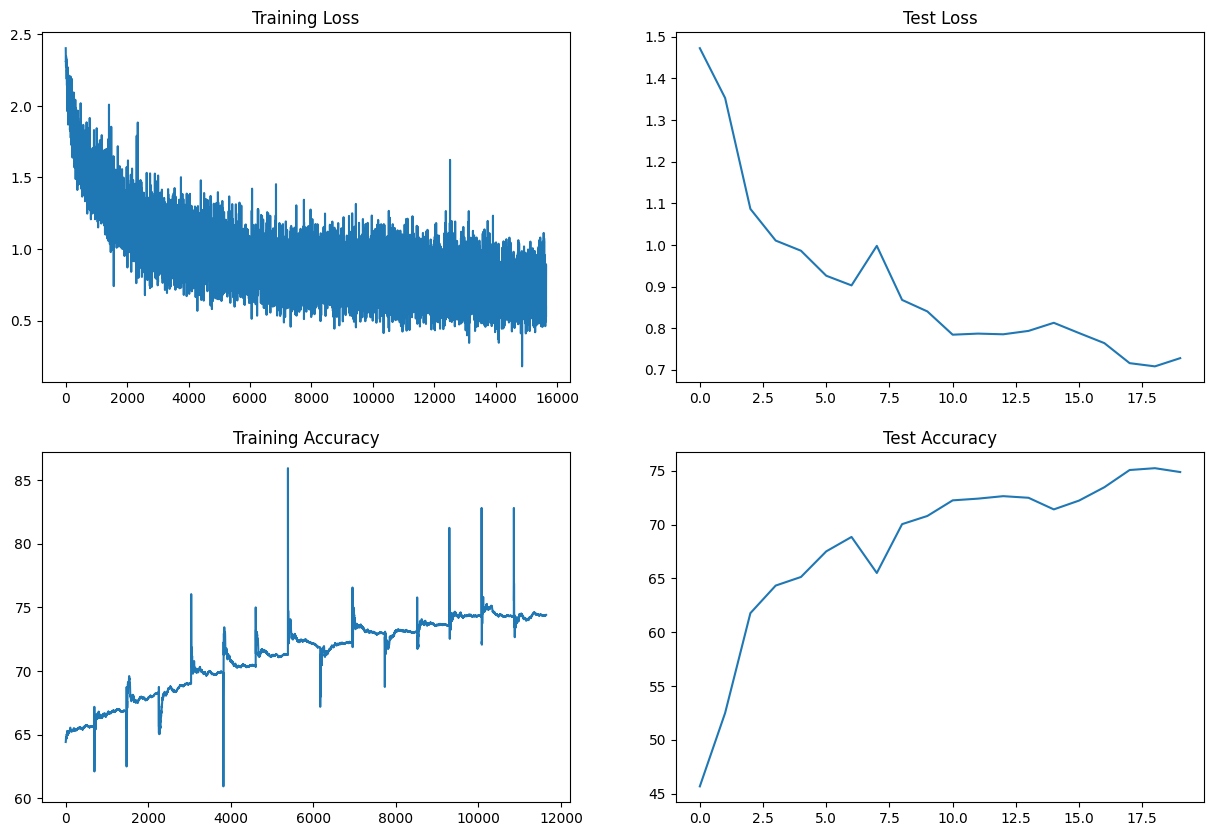

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
import numpy as np

def misclassified(model, testloader):
  classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  # Testing the model and printing misclassified images
  misclassified_images = []
  misclassified_labels = []
  predicted_label_list = []
  for index in range(500):
      k = np.random.randint(0, len(test_dataloader.dataset))  # random points from test dataset

      img, label = test_dataloader.dataset[k]  # separate the image and label
      img = img.unsqueeze(0)  # adding one dimention
      pred = model(img.to(device))  # Prediction
      predicted_label = pred.argmax().item()
      if label != predicted_label:
          misclassified_labels.append(classes[label])
          misclassified_images.append(img)
          predicted_label_list.append(classes[predicted_label])
      if len(misclassified_labels) == 10:
          break
  print(misclassified_labels)
  plt.figure(figsize=(10, 5))
  for i in range(10):
      plt.subplot(2, 5, i + 1)
      plt.imshow(misclassified_images[i].squeeze().permute(1,2,0), cmap="gray")
      plt.title(f"Predcited label {predicted_label_list[i]}\n True Label: {misclassified_labels[i]}")
      plt.axis('off')
  plt.show()



['dog', 'truck', 'horse', 'deer', 'truck', 'deer', 'cat', 'horse', 'truck', 'bird']


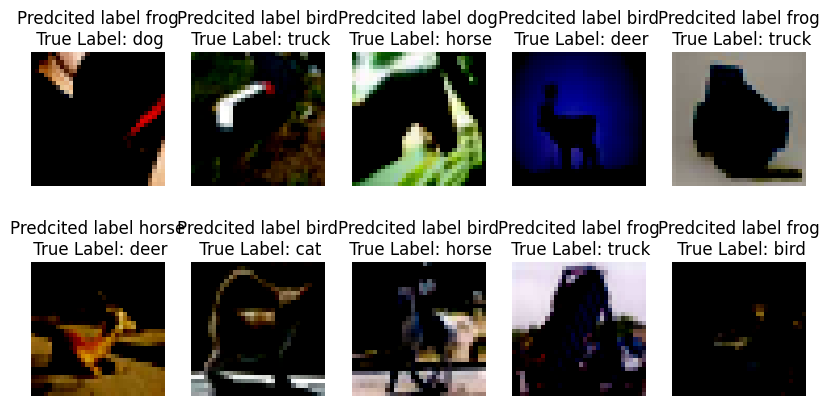

In [ ]:
misclassified(model, test_dataloader)